<a href="https://colab.research.google.com/github/ddopp4877/single-cell-tuning/blob/main/test_cell_with_syns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade numpy==1.24.4 pandas==2.2.2 scipy==1.11.3> /dev/null 2>&1

import os
os.kill(os.getpid(), 9)#restart so the above packages can be used

In [1]:
# If running in Colab
!pip install --upgrade pip2 > /dev/null 2>&1
!pip install --quiet allensdk neuron > /dev/null 2>&1
!git clone -b release_candidate https://github.com/V-Marco/ACT.git > /dev/null 2>&1

In [1]:
!pip install --quiet allensdk neuron

In [2]:
# Mouse L2/3 PV cell
# https://celltypes.brain-map.org/experiment/electrophysiology/484635029
specimen_id = 484635029

model_type = 'perisomatic'#or 'all active'
work_dir = 'OriginalFromAllenDB'

In [3]:
from allensdk.model.biophys_sim.config import Config
from allensdk.model.biophysical.utils import Utils
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("ACT")
from act.passive import ACTPassiveModule

/home/hrbncv/miniconda3/envs/BMTK/lib/python3.9/site-packages/torch/__init__.py:1240: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


In [4]:
from allensdk.api.queries.biophysical_api import BiophysicalApi
from allensdk.model.biophys_sim.config import Config
from allensdk.model.biophysical.utils import Utils

In [5]:
#get the model id

bp = BiophysicalApi()#using AllenDB's API
models = bp.get_neuronal_models(specimen_id)

for model in models:
  if model_type in model['name'].lower():
    print(f"model id = {model['id']}\n")
    model_id = model['id']
models

model id = 485602029



[{'id': 485602029,
  'name': 'Biophysical - perisomatic_Pvalb-IRES-Cre;Ai14-201791.05.01.01',
  'neuron_reconstruction_id': 496079599,
  'neuronal_model_template_id': 329230710,
  'specimen_id': 484635029},
 {'id': 496538965,
  'name': 'Biophysical - all active_Pvalb-IRES-Cre;Ai14-201791.05.01.01',
  'neuron_reconstruction_id': 496079599,
  'neuronal_model_template_id': 491455321,
  'specimen_id': 484635029}]

In [6]:
# Download the cell
bp.cache_stimulus = False # Change to False to not download the large stimulus NWB file
bp.cache_data(model_id, working_directory = work_dir )
os.chdir(work_dir)

2025-05-27 15:00:17,577 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/496079601
2025-05-27 15:00:18,110 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/496605128
2025-05-27 15:00:18,366 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/395337293
2025-05-27 15:00:18,707 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/395337054
2025-05-27 15:00:19,008 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/395337225
2025-05-27 15:00:19,296 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/395337019
2025-05-27 15:00:19,601 allensdk.api.api.retrieve_fi

In [7]:
import requests
path = "https://raw.githubusercontent.com/yzerlaut/pv-sst-dendrites/main/detailed_model/mechanisms"
filenames = ['NMDAIN.mod','vecstim.mod','cpampain.mod', 'gabaain.mod']

for filename in filenames:

  url = os.path.join(path,filename)
  response = requests.get(url)

  if response.status_code == 200:
      with open(os.path.join('modfiles',filename), 'w') as f:#assuming you are in work_dir and the mechanisms are in a folder called 'modflies'
          f.write(response.text)
  else:
      print(f"Failed to download file: {response.status_code}")

In [8]:
# Compile the modfiles

!nrnivmodl modfiles > /dev/null 2>&1

In [9]:
import sys, os
from functools import wraps

def suppress_output(fn):
    @wraps(fn)
    def wrapper(*args, **kwargs):
        devnull = open(os.devnull, 'w')
        old_stdout, old_stderr = sys.stdout, sys.stderr
        sys.stdout = sys.stderr = devnull
        try:
            return fn(*args, **kwargs)
        finally:
            sys.stdout, sys.stderr = old_stdout, old_stderr
            devnull.close()
    return wrapper

In [10]:
@suppress_output
def build_cell(soma_diam_multiplier = 1,using_hoc=False,hoc_filename=None,cell_name=None):

    if using_hoc:
      from neuron import h
      h.load_file(hoc_filename)
      return getattr(h, cell_name)()
    # Create the h object
    description = Config().load('manifest.json')
    utils = Utils(description)
    h = utils.h
    # Convert all "value" attributes to floats
    for dict in utils.description.data['genome']:
        for key, value in dict.items():
            if key == 'value': dict[key] = float(value)
    # Configure morphology
    morphology_path = description.manifest.get_path('MORPHOLOGY')
    utils.generate_morphology(morphology_path.encode('ascii', 'ignore'))
    utils.load_cell_parameters()
    # To match PP
    h.soma[0].diam = h.soma[0].diam * soma_diam_multiplier

    return h

In [11]:
from neuron import h
h.load_file("stdrun.hoc")  # Required to use h.run()



--No graphics will be displayed.


1.0

In [12]:
def run(h):

  nmda = h.CPGLUIN(0.5,h.dend[32])
  vecstim = h.VecStim()
  times = h.Vector([500])
  vecstim.play(times)
  rec_times = h.Vector()
  nc = h.NetCon(vecstim, None)  # No target, just record events
  nc.record(rec_times)
  nmdaNetCON = h.NetCon(vecstim,nmda)
  nmdaNetCON.weight[0] = 0.0001

  v = h.Vector().record(h.dend[32](0.5)._ref_v)
  i  = h.Vector().record(nmda._ref_iglu)
  h.finitialize()
  h.dt=0.025
  h.tstop = 1000
  h.run()
  return v,rec_times,times,i

In [13]:
h = build_cell(1)#redifine/add ? to h so as to avoid run() conflict?
v,nc,times,i = run(h)

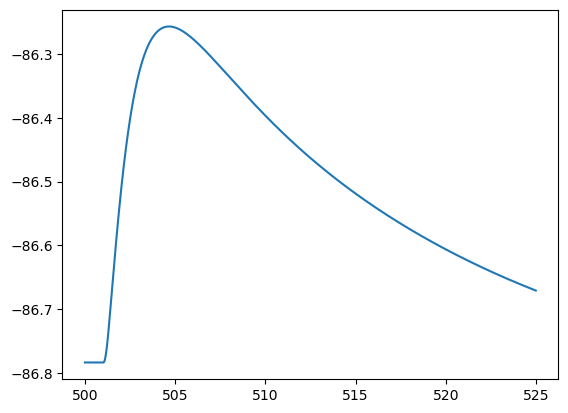

In [14]:
start, end = 20000,21000

V = v.as_numpy()
times = np.arange(0,1000.025,0.025)
plt.plot(times[start:end],V[start:end])

#Automated

In [15]:
def create_syns(h,syn_point_proc, seg,dend_sec_no, nsyn):
  syns =  [syn_point_proc(seg, h.dend[int(dend_sec_no)]) for i in range(nsyn)]
  return syns

In [16]:
def insert_syns(h,sim_params,name):

  nsyns = sim_params['nsyn_exc']

  point_proc_name = f"{name}_point_proc"

  seg = sim_params[f"{name}_seg"]
  sec = sim_params[f"{name}_sec"]

  syns = create_syns(h,sim_params[point_proc_name],seg,sec,sim_params['nsyn_exc'])
  vec_stims = [h.VecStim() for i in range(nsyns)]
  event_times_vectors = [h.Vector(sim_params["event_times"][i]) for i in range(nsyns)]

  ncs = []
  for i in range(nsyns):
    vec_stims[i].play(event_times_vectors[i])
    nc = h.NetCon(vec_stims[i],syns[i])
    nc.weight[0] = sim_params[f"{name}_weight"]
    ncs.append(nc)

  return_dict = {"nsyns": nsyns,
                  "syns": syns,
                  "vec_stims": vec_stims,
                  "event_times_vectors":event_times_vectors,
                  "ncs":ncs}

  return return_dict


In [18]:

def run(h,sim_params):

  nsyns = sim_params['nsyn_exc']

  ampa_return_dict = insert_syns(h,sim_params,'ampa')
  # nmda_return_dict = insert_syns(h,sim_params,'nmda')

  # v = h.Vector().record(h.dend[33](0.67)._ref_v)
  v = h.Vector().record(h.soma[0](0.5)._ref_v)
  h.finitialize()
  h.dt=0.025
  h.tstop = 1000
  h.run()

  return v

In [ ]:
import numpy as np
from scipy.integrate import quad

def average_syn_density(seg,
                        dis_eq,
                        **eq_params) -> float:
    """
    Return the mean synaptic density (synapses / µm) in a dendritic
    sub-segment.

    Parameters
    ----------
    seg : (sec,seg)
        Segment adding synapses to.
    dis_eq    : callable
        Your density equation f(x, **eq_params) → density (synapses / µm).
        Example signature:  def my_eq(x, a, tau): ...
    **eq_params :
        Named parameters required by `dis_eq` (optional).

    Returns
    -------
    float
        Average density over segment in section.
    """


    if soma_ref is None:
        soma_ref = cell.soma[0]        # works for both template & global

    h.distance(0, 0.5, sec=soma_ref)

    nseg  = int(sec.nseg)
    if not (0 <= xmid < 1):
        raise ValueError("xmid must be in the half-open interval [0, 1)")

    # Integrate density along the segment
    integral, _ = quad(lambda x: dis_eq(x, **eq_params), seg_start, seg_end)

    # Mean density = area / length
    syn_dens = integral / (seg_end - seg_start)

    return syn_dens


In [ ]:
def find_syn_dens(seg_start, seg_end):

    pv_dis_eq = f*x

    
    sst_dis_eq = 2 * x

    return syn_dens

In [19]:
def set_seg_stim_params(syn_range, syn_dens, nsyn_temp, syn_wts, syn_seg, syn_sec, inc_nmda):
    """
    syn_range: length of range for synapses added (proximal/distal)
    syn_dens: synaptic density, calc in find_syn_dens
    syn_wts: list of syn weights for AMPA, NMDA, GABA respectively
    syn_seg: location of seg in dend sec (0-1)
    syn_sec: dend sec for syns
    """

    stim_start = 400
    stim_int = 0.5

    section_range = syn_range
    syn_pct = 0.04

    # seg_start = sec[syn_sec](syn_seg(0)) #not real, need real code
    # seg_end = sec[syn_sec](syn_seg(1)) #not real, need real code
    # syn_dens = find_syn_dens(seg_start,seg_end) # need distribution
    syn_dens = 2 #fixed for now

    nsyn = int(section_range * syn_pct * syn_dens)

    nsyn_exc = 0.8 * nsyn
    nsyn_exc = nsyn_temp
    if inc_nmda:
        nsyn_nmda = nsyn_exc
    else:
        nsyn_nmda = 0

    nsyn_inh = 0.2 * nsyn
    nsyn_inh = 0

    stim_times = [[stim_start + i * stim_int] for i in range(nsyn_exc)]

    syn_seg = syn_seg   # "ampa_seg": 0.5, #13:0.5; 14:0.17
    syn_sec = syn_sec   # "ampa_sec": 13, # For sec 16 (dist), secs 13/14 (proximal)

    sim_params = {"event_times": stim_times,

                    "ampa_weight": syn_wts[0],
                    "ampa_point_proc": h.CPGLUIN,
                    "ampa_seg": syn_seg, #13:0.5; 14:0.17
                    "ampa_sec": syn_sec, # For sec 16 (dist), secs 13/14 (proximal)
                    "nsyn_exc": nsyn_exc,
                    
                    # "nmda_weight": syn_wts[1],
                    # "nmda_point_proc": h.NMDAIN,
                    # "nmda_seg": syn_seg,
                    # "nmda_sec": syn_sec,
                    # "nsyn_exc": nsyn_nmda,

                    # "gaba_weight": syn_wts[2],
                    # "gaba_point_proc": h.gabaain,
                    # "gaba_seg": syn_seg,
                    # "gaba_sec": syn_sec,
                    # "nsyn_inh": nsyn_inh,
                  
                }

    return sim_params

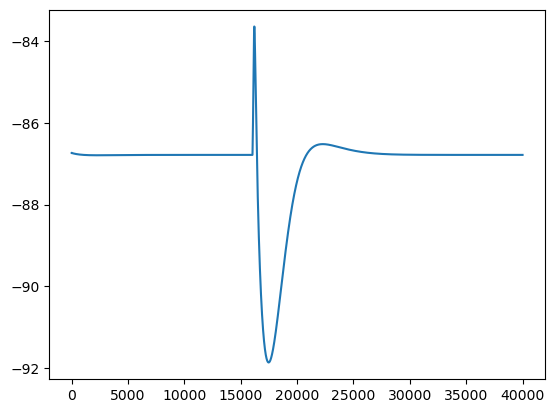

In [20]:
sim_params = set_seg_stim_params(syn_range=40, syn_wts=[0.0001,0,0], 
                                    syn_dens = 2, nsyn_temp = 7,
                                    syn_seg=0.5, syn_sec=13,
                                    inc_nmda = False)


h = build_cell(1)#redifine/add ? to h so as to avoid run() conflict?
v= run(h,sim_params)
# v = v.as_numpy()


plt.plot(v)

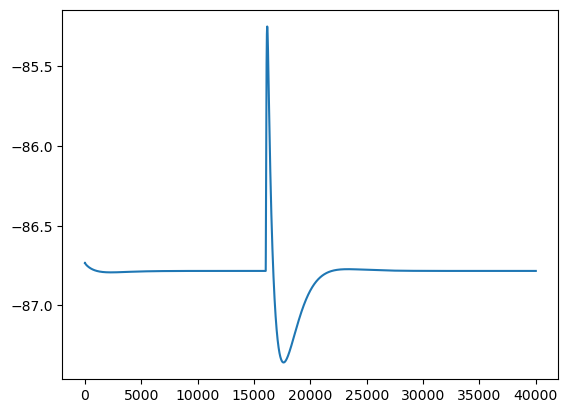

In [21]:
nsyn_exc = int(40 *.04 * 2)
sim_params = {"event_times":[[400], [400.5],[401]],
              "ampa_weight": 0.0001,
              "ampa_point_proc": h.CPGLUIN,
              "ampa_seg": 0.5,
              "ampa_sec": 32,

            #   "nmda_weight": 0.005,
            #   "nmda_point_proc": h.NMDAIN,
            #   "nmda_seg": 0.5,
            #   "nmda_sec": 32,

              "nsyn_exc":3
              }



h = build_cell(1)#redifine/add ? to h so as to avoid run() conflict?
v= run(h,sim_params)
# v = v.as_numpy()



plt.plot(v)

#proximal

real

In [24]:
stim_start = 400
stim_int = 0.5

section_range = 40
syn_pct = 0.04
syn_dens = 2
nsyn_exc = int(section_range * syn_pct * syn_dens)
nsyn_exc = 3

stim_times = [[stim_start + i * stim_int] for i in range(nsyn_exc)]
# print(stim_times)

sim_params = {"event_times": stim_times,
              "ampa_weight": 0.0001,
              "ampa_point_proc": h.CPGLUIN,
              "ampa_seg": 0.5, #13:0.5; 14:0.17
              "ampa_sec": 13, # For sec 16 (dist), secs 13/14 (proximal)

            #   "nmda_weight": 0.005,
            #   "nmda_point_proc": h.NMDAIN,
            #   "nmda_seg": 0.5,
            #   "nmda_sec": 32,

              "nsyn_exc": nsyn_exc
              }

Text(0.5, 1.0, 'Proximal Real')

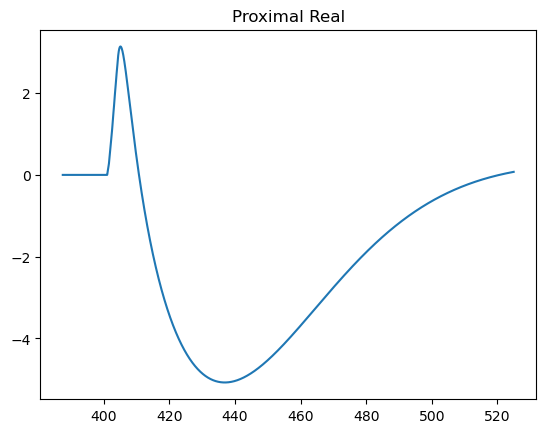

In [ ]:
sim_params = set_seg_stim_params(syn_range=40, syn_wts=[0.0001,0,0], 
                                    syn_dens = 2, nsyn_temp = 7,
                                    syn_seg=0.5, syn_sec=13,
                                    inc_nmda = False)


h = build_cell(1)#redifine/add ? to h so as to avoid run() conflict?
v= run(h,sim_params)
v = v.as_numpy()

tstart = int(sim_params["event_times"][0][0]-500)
tstop = int(tstart +50)
vrest = np.mean(v[tstart:tstop])
corrected_v = v-vrest
corrected_v = np.array(corrected_v)


start, end = int(sim_params["event_times"][0][0]/0.025 - 500), int(sim_params["event_times"][0][0]/0.025 + 5000)
real = corrected_v[start:end]
times = np.arange(0,1000.025,0.025)
t = times[start:end]
plt.plot(t,real)
plt.title("Proximal Real")

expected

In [ ]:
stim_start = 400
stim_int = 0.5

section_range = 40
syn_pct = 0.04
syn_dens = 2
nsyn_exc = int(section_range * syn_pct * syn_dens)
nsyn_exc = 7

stim_times = [stim_start + i * stim_int for i in range(nsyn_exc)]
# print(stim_times)

sim_params = {"event_times": stim_times,
              "ampa_weight": 0.0001,
              "ampa_point_proc": h.CPGLUIN,
              "ampa_seg": 0.5, #13:0.5; 14:0.17
              "ampa_sec": 13, # For sec 16 (dist), secs 13/14 (proximal)

            #   "nmda_weight": 0.005,
            #   "nmda_point_proc": h.NMDAIN,
            #   "nmda_seg": 0.5,
            #   "nmda_sec": 32,

              "nsyn_exc": nsyn_exc
              }

In [479]:
h = build_cell(1)#redifine/add ? to h so as to avoid run() conflict?
v= run(h,sim_params)
v = v.as_numpy()



In [480]:
tstart = sim_params["event_times"][0][0]-500
tstop = tstart +4
vrest = np.mean(v[tstart:tstop])
corrected_v = v-vrest#use the same vrest as for real
corrected_v = np.array(corrected_v)

Text(0.5, 1.0, 'Expected')

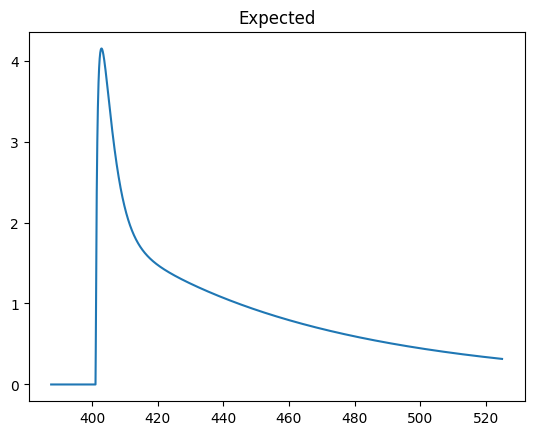

In [481]:
start, end = int(sim_params["event_times"][0][0]/0.025 - 500), int(sim_params["event_times"][0][0]/0.025 + 5000)
expected = corrected_v[start:end]*3
times = np.arange(0,1000.025,0.025)
t = times[start:end]
plt.plot(t,expected)
plt.title("Expected")

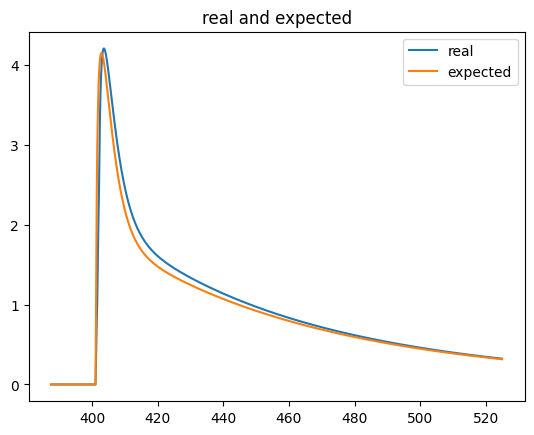

In [483]:
plt.plot(t,real,label="real")
plt.plot(t,expected,label="expected")
plt.legend()
plt.title("real and expected")
plt.show()

#Distal

In [ ]:
stim_start = 400
stim_int = 0.5

section_range = 40
syn_pct = 0.04
syn_dens = 2
nsyn_exc = int(section_range * syn_pct * syn_dens)
nsyn_exc = 7

stim_times = [stim_start + i * stim_int for i in range(nsyn_exc)]
# print(stim_times)

sim_params = {"event_times": stim_times,
              "ampa_weight": 0.0001,
              "ampa_point_proc": h.CPGLUIN,
              "ampa_seg": 0.5, #13:0.5; 14:0.17
              "ampa_sec": 13, # For sec 16 (dist), secs 13/14 (proximal)

            #   "nmda_weight": 0.005,
            #   "nmda_point_proc": h.NMDAIN,
            #   "nmda_seg": 0.5,
            #   "nmda_sec": 32,

              "nsyn_exc": nsyn_exc
              }

In [509]:
h = build_cell(1)#redifine/add ? to h so as to avoid run() conflict?
v= run(h,sim_params)
v = v.as_numpy()

In [510]:

tstart = sim_params["event_times"][0][0]-500
tstop = tstart +50
vrest = np.mean(v[tstart:tstop])
corrected_v = v-vrest
corrected_v = np.array(corrected_v)

Text(0.5, 1.0, 'Distal Real')

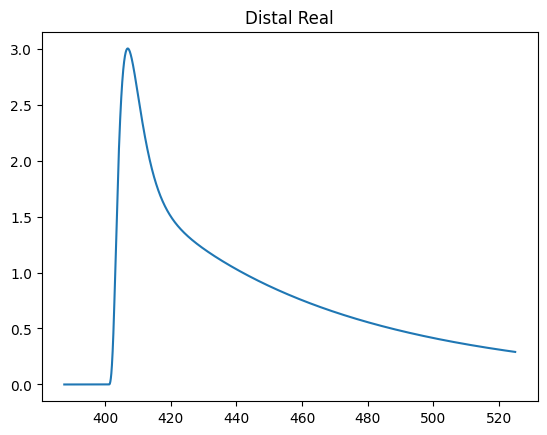

In [511]:
start, end = int(sim_params["event_times"][0][0]/0.025 - 500), int(sim_params["event_times"][0][0]/0.025 + 5000)
real = corrected_v[start:end]
plt.plot(t,real)
plt.title("Distal Real")

#Distal expected

In [ ]:
stim_start = 400
stim_int = 0.5

section_range = 40
syn_pct = 0.04
syn_dens = 2
nsyn_exc = int(section_range * syn_pct * syn_dens)
nsyn_exc = 7

stim_times = [stim_start + i * stim_int for i in range(nsyn_exc)]
# print(stim_times)

sim_params = {"event_times": stim_times,
              "ampa_weight": 0.0001,
              "ampa_point_proc": h.CPGLUIN,
              "ampa_seg": 0.5, #13:0.5; 14:0.17
              "ampa_sec": 13, # For sec 16 (dist), secs 13/14 (proximal)

            #   "nmda_weight": 0.005,
            #   "nmda_point_proc": h.NMDAIN,
            #   "nmda_seg": 0.5,
            #   "nmda_sec": 32,

              "nsyn_exc": nsyn_exc
              }

In [505]:
h = build_cell(1)#redifine/add ? to h so as to avoid run() conflict?
v= run(h,sim_params)
v = v.as_numpy()

In [506]:
tstart = sim_params["event_times"][0][0]-500
tstop = tstart +50
vrest = np.mean(v[tstart:tstop])
corrected_v = v-vrest
corrected_v = np.array(corrected_v)

Text(0.5, 1.0, 'Distal Expected')

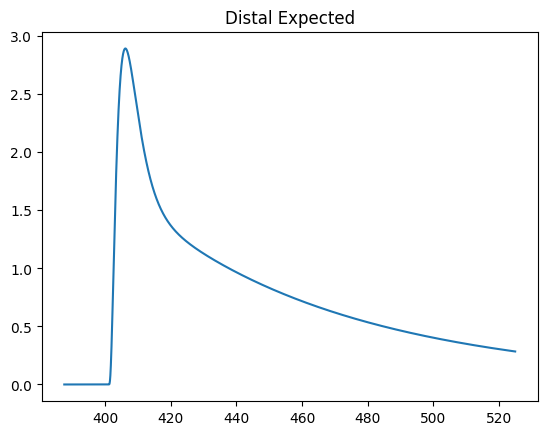

In [507]:
start, end = int(sim_params["event_times"][0][0]/0.025 - 500), int(sim_params["event_times"][0][0]/0.025 + 5000)
expected = corrected_v[start:end] * 3
plt.plot(t,expected)
plt.title("Distal Expected")

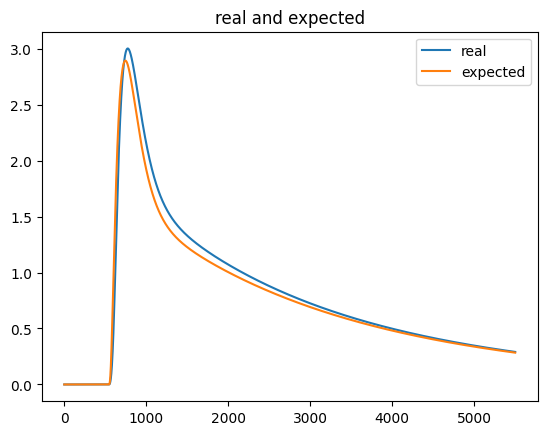

In [512]:
plt.plot(real,label="real")
plt.plot(expected,label="expected")
plt.legend()
plt.title("real and expected")
plt.show()

#distal no nmda

In [ ]:
stim_start = 400
stim_int = 0.5

section_range = 40
syn_pct = 0.04
syn_dens = 2
nsyn_exc = int(section_range * syn_pct * syn_dens)
nsyn_exc = 7

stim_times = [stim_start + i * stim_int for i in range(nsyn_exc)]
# print(stim_times)

sim_params = {"event_times": stim_times,
              "ampa_weight": 0.0001,
              "ampa_point_proc": h.CPGLUIN,
              "ampa_seg": 0.5, #13:0.5; 14:0.17
              "ampa_sec": 13, # For sec 16 (dist), secs 13/14 (proximal)

            #   "nmda_weight": 0.005,
            #   "nmda_point_proc": h.NMDAIN,
            #   "nmda_seg": 0.5,
            #   "nmda_sec": 32,

              "nsyn_exc": nsyn_exc
              }

In [610]:
h = build_cell(1)#redifine/add ? to h so as to avoid run() conflict?
v= run(h,sim_params)
v = v.as_numpy()

In [611]:
tstart = sim_params["event_times"][0][0]-500
tstop = tstart +50
vrest = np.mean(v[tstart:tstop])
corrected_v = v-vrest
corrected_v = np.array(corrected_v)

Text(0.5, 1.0, 'Distal real no NMDA')

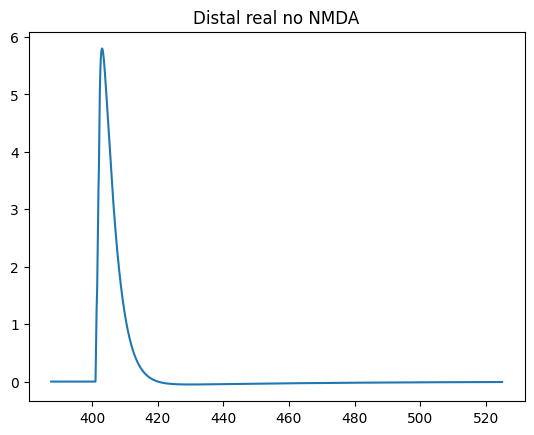

In [612]:
start, end = int(sim_params["event_times"][0][0]/0.025 - 500), int(sim_params["event_times"][0][0]/0.025 + 5000)
real = corrected_v[start:end]
times = np.arange(0,1000.025,0.025)
t = times[start:end]
plt.plot(t,real)
plt.title("Distal real no NMDA")

In [ ]:
stim_start = 400
stim_int = 0.5

section_range = 40
syn_pct = 0.04
syn_dens = 2
nsyn_exc = int(section_range * syn_pct * syn_dens)
nsyn_exc = 7

stim_times = [stim_start + i * stim_int for i in range(nsyn_exc)]
# print(stim_times)

sim_params = {"event_times": stim_times,
              "ampa_weight": 0.0001,
              "ampa_point_proc": h.CPGLUIN,
              "ampa_seg": 0.5, #13:0.5; 14:0.17
              "ampa_sec": 13, # For sec 16 (dist), secs 13/14 (proximal)

            #   "nmda_weight": 0.005,
            #   "nmda_point_proc": h.NMDAIN,
            #   "nmda_seg": 0.5,
            #   "nmda_sec": 32,

              "nsyn_exc": nsyn_exc
              }

In [606]:
h = build_cell(1)#redifine/add ? to h so as to avoid run() conflict?
v= run(h,sim_params)
v = v.as_numpy()

In [607]:
tstart = sim_params["event_times"][0][0]-500
tstop = tstart +50
vrest = np.mean(v[tstart:tstop])
corrected_v = v-vrest
corrected_v = np.array(corrected_v)

Text(0.5, 1.0, 'Distal expected no NMDA')

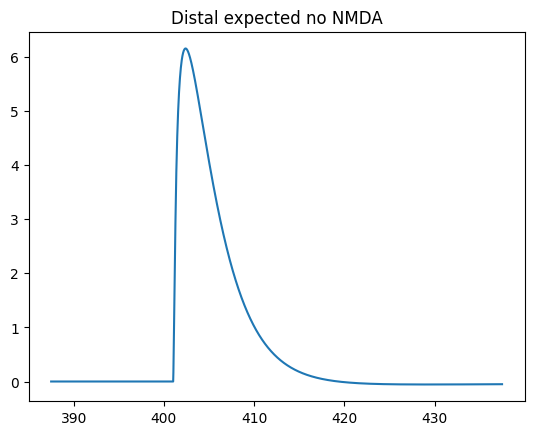

In [608]:
start, end = int(sim_params["event_times"][0][0]/0.025 - 500), int(sim_params["event_times"][0][0]/0.025 + 5000)
expected = corrected_v[start:end] *3
plt.plot(t[:2000],expected[:2000])
plt.title("Distal expected no NMDA")

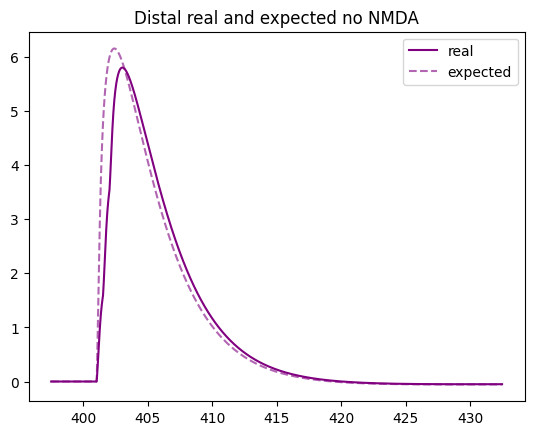

In [613]:
times = np.arange(0,1000.025,0.025)
t = times[start:end]

plt.plot(t[400:1800],real[400:1800],color ="purple", label="real")
plt.plot(t[400:1800],expected[400:1800],color ="purple",linestyle='dashed',label="expected",alpha = 0.6)

plt.legend()
plt.title("Distal real and expected no NMDA")
plt.show()